<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Working/StocksApp_DashApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 1: Set Up**


In [1]:
# #-----refesh python script-------#
# get_ipython().kernel.do_shutdown(restart=True)

# #----GPU Setup------#
# #Check GPUs
# !nvidia-smi

# #load cudf to use GPUs for analysis
# %load_ext cudf.pandas


#------Imports--------#
import pandas as pd
import datetime
import pickle
import numpy as np
import requests
import time
import os


#-------Froms-------#
from tqdm.notebook import tqdm
from datetime import datetime, timedelta


# #------Force Connect MyDrive-------#
# from google.colab import drive
# drive.mount('/content/drive')


# **Section 2: Stock Data**

## Ensure the last 6 months of EODHD Data is available

In [3]:
# Ensure the last 6 months of EODHD Data is available
"""
Returns:
nasdaq_df:
  <class 'pandas.core.frame.DataFrame'>
  RangeIndex: 627225 entries, 0 to 627224
  Data columns (total 8 columns):
  #   Column          Non-Null Count   Dtype
  ---  ------          --------------   -----
  0   date            627225 non-null  datetime64[ns]
  1   ticker          627098 non-null  object
  2   open            627225 non-null  float64
  3   high            627225 non-null  float64
  4   low             627225 non-null  float64
  5   close           627225 non-null  float64
  6   adjusted_close  627225 non-null  float64
  7   volume          627225 non-null  float64
"""
#API_KEY = 'demo'  # Replace with your API key if not using demo
API_KEY = '68433aff09ea73.10710364'
EXCHANGE = 'NASDAQ'
DAYS_BACK = 180  # Approx. 6 months
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv'
MAX_CALLS_PER_RUN = 200  # Use 1–5 for the free tier
SECONDS_BETWEEN_CALLS = 0  # Add delay to be respectful

# Generate past 6 months of weekdays
today = datetime.utcnow().date()
dates = [today - timedelta(days=i) for i in range(DAYS_BACK)]
dates = sorted([d for d in dates if d.weekday() < 5])  # Keep only weekdays

# Load already-downloaded dates if file exists
downloaded_dates = set()
if os.path.exists(SAVE_PATH):
    df_existing = pd.read_csv(SAVE_PATH)
    downloaded_dates = set(pd.to_datetime(df_existing['date']).dt.date)
# Filter to only dates we haven’t downloaded
pending_dates = [d for d in dates if d not in downloaded_dates]

# Prepare data holder
all_data = []

for i, date in enumerate(pending_dates[:MAX_CALLS_PER_RUN]):
    date_str = date.strftime('%Y-%m-%d')
    url = f'https://eodhd.com/api/eod-bulk-last-day/{EXCHANGE}?api_token={API_KEY}&fmt=json&date={date_str}'
    print(f"[{i+1}] Fetching {date_str}...")

    try:
        response = requests.get(url)
        response.raise_for_status()
        day_data = response.json()

        for entry in day_data:
            all_data.append({
                'date': entry.get('date'),
                'ticker': entry.get('code'),
                'open': entry.get('open'),
                'high': entry.get('high'),
                'low': entry.get('low'),
                'close': entry.get('close'),
                'adjusted_close': entry.get('adjusted_close'),
                'volume': entry.get('volume'),
            })

        # Respect the delay
        if i < MAX_CALLS_PER_RUN - 1:
            time.sleep(SECONDS_BETWEEN_CALLS)

    except Exception as e:
        print(f"⚠️ Error on {date_str}: {e}")

# Append or save the new data
if all_data:
    df_new = pd.DataFrame(all_data)
    if os.path.exists(SAVE_PATH):
        df_existing = pd.read_csv(SAVE_PATH)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(SAVE_PATH, index=False)
    print(f"✅ Data for {len(all_data)} entries added to {SAVE_PATH}")

else:
    print("⚠️ No new data fetched.")


# Import CSV into code
nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")

# Save the latest date in YYYYMMDD format
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])
latest_date_nasdaq_data = nasdaq_df['date'].max().strftime('%Y%m%d')

[1] Fetching 2025-06-17...
✅ Data for 1 entries added to /content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv


## Get list of Tickers with Min Market Cap and populate screener_data_df

In [4]:
# Get list of Tickers with a min market cap and a list of common stocks
"""
Returns:
screener_data_df:
  <class 'pandas.core.frame.DataFrame'>
  RangeIndex: 262 entries, 0 to 261
  Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
  ---  ------                 --------------  -----
 0   code                   262 non-null    object
 1   name                   262 non-null    object
 2   last_day_data_date     262 non-null    object
 3   adjusted_close         262 non-null    float64
 4   refund_1d              262 non-null    float64
 5   refund_1d_p              262 non-null    float64
 6   refund_5d              262 non-null    float64
 7   refund_5d_p            262 non-null    float64
 8   exchange               262 non-null    object
 9   currency_symbol        262 non-null    object
 10  market_capitalization  262 non-null    int64
 11  earnings_share         262 non-null    float64
 12  dividend_yield         145 non-null    float64
 13  sector                 262 non-null    object
 14  industry               262 non-null    object
 15  avgvol_1d              262 non-null    int64
 16  avgvol_200d            262 non-null    float64
 17  Country                262 non-null    object
 18  Exchange               262 non-null    object
 19  Currency               262 non-null    object
 20  Type                   262 non-null    object
 21  last_day_change        262 non-null    float64

"""

# -------------------- CONFIG --------------------
API_KEY = '68433aff09ea73.10710364'  # Replace with your EODHD key
MIN_MARKET_CAP = 10_000_000_000  # Changeable: $1B, $10B, etc.
EXCHANGE = 'NASDAQ'
RESULTS_PER_PAGE = 500  # Max per EODHD API
# ------------------------------------------------

def get_filtered_nasdaq_stocks(api_key, min_cap, exchange="NASDAQ"):
    all_data = []
    offset = 0

    while True:
        url = (
            "https://eodhd.com/api/screener"
            f"?api_token={api_key}"
            f"&filters=["
            f'["exchange","=","{exchange}"],'
            #f'["type","=","Common Stock"],'
            f'["market_capitalization",">=",{min_cap}]'
            f"]"
            f"&sort=market_capitalization.desc"
            f"&limit={RESULTS_PER_PAGE}&offset={offset}&fmt=json"
        )

        response = requests.get(url)
        result = response.json()
        batch = result.get("data", [])

        if not batch:
            break

        all_data.extend(batch)
        offset += RESULTS_PER_PAGE

    return pd.DataFrame(all_data)

# Run filter to get screener_data_df
screener_data_df = get_filtered_nasdaq_stocks(API_KEY, MIN_MARKET_CAP)

# Get exchange symbol list with type
meta_url = f'https://eodhd.com/api/exchange-symbol-list/NASDAQ?api_token={API_KEY}&fmt=json'
meta_df = pd.DataFrame(requests.get(meta_url).json())
common_df = meta_df[meta_df['Type'] == 'Common Stock'].copy() # Add .copy() to avoid SettingWithCopyWarning

# Combine screener_data_df with relevant columns from common_df
screener_data_df = pd.merge(
    screener_data_df,
    common_df[['Code', 'Country', 'Exchange', 'Currency', 'Type']],
    left_on='code',
    right_on='Code',
    how='inner'
).drop('Code', axis=1)

# --- Calculate Daily Change ---
# Ensure 'date' column is datetime and sort by date
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])
temp_nasdaq_sorted = nasdaq_df.sort_values(by=['ticker', 'date']).copy()

# Calculate the previous day's adjusted close for each ticker
temp_nasdaq_sorted['prev_adjusted_close'] = temp_nasdaq_sorted.groupby('ticker')['adjusted_close'].shift(1)

# Calculate the daily change as a percentage
temp_nasdaq_sorted['daily_change'] = ((temp_nasdaq_sorted['adjusted_close'] - temp_nasdaq_sorted['prev_adjusted_close']) / temp_nasdaq_sorted['prev_adjusted_close']) * 100

# Get the last day's data for each ticker
last_day_data_per_ticker = temp_nasdaq_sorted.groupby('ticker').tail(1).copy()

# Create a dictionary of the last day's change for each ticker
last_day_changes = last_day_data_per_ticker.set_index('ticker')['daily_change'].to_dict()

# Add the last day change to the screener_data_df
screener_data_df['last_day_change'] = screener_data_df['code'].map(last_day_changes)

## Filter nasdaq data for screener_data_df and type: common

In [5]:
# prompt: I want to filter the Nasdaq stocks to only include tickers that are part of the common_df and the min_market_cap_df. Same this df as a new variable
# Load your EOD data
from datetime import datetime, timedelta
# nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

# Now filter nasdaq_df using the combined dataframe and type 'Common Stock'
filtered_nasdaq_df = nasdaq_df[
    nasdaq_df['ticker'].isin(screener_data_df[screener_data_df['Type'] == 'Common Stock']['code'])
]

## Function: Correlation Coeficient for entire stock data set

In [6]:
#return six month and three month spearman correlations for all unique pairs of stocks

import pandas as pd
from datetime import datetime # Import datetime
from tqdm.notebook import tqdm # Import tqdm

# ## Function: Correlation Coeficient for entire stock data set
def calculate_lagged_correlation(df, lag_days, range_months):
  """
  Calculates the pairwise spearman correlation coefficient between all stocks
  in a DataFrame for a specified period with a given lag.
  The start date is calculated by subtracting range_months from today's date.

  Args:
    df: DataFrame with 'date', 'ticker', and 'adjusted_close' columns.
    lag_days: The number of days to lag the second stock's data.
    range_months: The number of months to include in the analysis period.

  Returns:
    correlation_matrix: A pandas DataFrame with the following
      Index: Tickers
      Columns: Tickers
      Values: Spearman correlation coefficients between stocks
  """
  # Calculate the end date (today's date)
  end_datetime = datetime.now()

  # Calculate the start date for the specified period by subtracting range_months
  start_datetime = end_datetime - pd.DateOffset(months = range_months)


  # Ensure the 'date' column is in datetime format
  df['date'] = pd.to_datetime(df['date'])

  # Filter the DataFrame for the specified date range
  filtered_df = df[(df['date'] >= start_datetime) & (df['date'] <= end_datetime)].copy()

  # Filter out rows where volume is 0
  filtered_df = filtered_df[filtered_df['volume'] > 0].copy()

  # Get unique tickers in the filtered data
  tickers = filtered_df['ticker'].unique()

  #breakpoint()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker and name the series for clarity
    stock_a_data = filtered_df[filtered_df['ticker'] == ticker_a].set_index('date')['adjusted_close']
    #breakpoint()

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker and name the series for clarity
        stock_b_data = filtered_df[filtered_df['ticker'] == ticker_b].set_index('date')['adjusted_close']
        #breakpoint()

        # Align the dataframes based on the date index
        # Suffixes will be applied to the 'adjusted_close' column name
        aligned_data = pd.merge(stock_a_data, stock_b_data,
                                left_index=True, right_index=True,
                                how='inner', suffixes=('_A', '_B'))

        # Apply the lag to stock_b_data, referencing the suffixed column name
        lagged_stock_b_data = aligned_data['adjusted_close_B'].shift(lag_days)

        #breakpoint()

        # Calculate correlation, dropping NaN values
        # Using Spearman method and minimum periods
        #correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman', min_periods=100)

        correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman')


        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix


# Check GoogleDrive for latest_date_nasdaq_data, in not run the correlation function
"""
Returns:
  three_month_spearman_lagged_correlations and six_month_spearman_lagged_correlations: A pandas DataFrame with the following
    Index: Tickers
    Columns: Tickers
    Values: Spearman correlation coefficients between stocks
"""
import pandas as pd
import os
from datetime import datetime, timedelta

# Define the file paths in Google Drive using the determined date
three_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{latest_date_nasdaq_data}_three_month_spearman_lagged_correlation.csv'
six_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{latest_date_nasdaq_data}_six_month_spearman_lagged_correlation.csv'

# Check if files exist and load them
try:
    three_month_spearman_lagged_correlations = pd.read_csv(three_month_file, index_col=0)
    print(f"Loaded existing file: {three_month_file}")
    six_month_spearman_lagged_correlations = pd.read_csv(six_month_file, index_col=0)
    print(f"Loaded existing file: {six_month_file}")

except FileNotFoundError:
    print("One or both correlation files not found. Calculating correlations...")
    # Calculate correlations if files don't exist
    # Ensure 'filtered_nasdaq_df' is defined from the preceding code
    if 'filtered_nasdaq_df' in locals():
        three_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=3)
        six_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=6)

        three_month_spearman_lagged_correlations.to_csv(three_month_file)
        print(f"Saved calculated file: {three_month_file}")
        six_month_spearman_lagged_correlations.to_csv(six_month_file)
        print(f"Saved calculated file: {six_month_file}")
    else:
        print("Error: 'filtered_nasdaq_df' is not defined. Please ensure the preceding code ran correctly.")

One or both correlation files not found. Calculating correlations...


<ipython-input-6-3716170834>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Calculating correlations:   0%|          | 0/259 [00:00<?, ?it/s]

<ipython-input-6-3716170834>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Calculating correlations:   0%|          | 0/259 [00:00<?, ?it/s]

Saved calculated file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250617_three_month_spearman_lagged_correlation.csv
Saved calculated file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250617_six_month_spearman_lagged_correlation.csv


## Process correlated Data and get gravitational scores

In [7]:
import pandas as pd
import numpy as np

# Function to process stock correlation data, calculate gravitational forces,
# and filter connections for visualization based on the force.
def process_and_score_stocks(
    six_month_correlations,
    three_month_correlations,
    screener_data_df,
    source_ticker,
    min_nodes,
    max_nodes,
    threshold_percent
):
    """
    Processes stock correlation data for a specific source ticker.
    It filters for positive correlations, computes a dynamic impact score (gravitational_force),
    filters connections, and then calculates a final net gravitational force and the
    maximum potential force under ideal conditions.

    Args:
      six_month_correlations: The six-month spearman lagged correlation matrix.
      three_month_correlations: The three-month spearman lagged correlation matrix.
      screener_data_df: DataFrame with additional stock information.
      source_ticker: The ticker symbol for which to process data.
      min_nodes: Minimum number of correlated stocks to return.
      max_nodes: Maximum number of correlated stocks to return.
      threshold_percent: A percentage (0.0 to 1.0) of the maximum force to use as a filter.

    Returns:
      processed_data_df: A pandas DataFrame with processed data for visualization.
      source_data_df: A pandas DataFrame containing the net_gravitational_force,
                      max_potential_force, and gravitational_impact for the source ticker,
                      along with the source ticker's market cap influence and source_planet_radius.
    """
    # --- Data Unpivoting and Initial Setup ---
    # Start with the 6-month correlation data as the base
    correlation_df = six_month_correlations.rename_axis('source', axis=0)
    grouped_correlation_data = correlation_df.stack().reset_index()
    grouped_correlation_data.columns = ['source', 'target', 'six_month_spearman_correlation']

    grouped_correlation_data = grouped_correlation_data[
        (grouped_correlation_data['source'] != grouped_correlation_data['target']) &
        (grouped_correlation_data['target'] != source_ticker)
    ].copy()

    # --- Filter for the specific source ticker ---
    source_connections = grouped_correlation_data[grouped_correlation_data['source'] == source_ticker].copy()
    if source_connections.empty:
        print(f"No correlation data found for source ticker {source_ticker}.")
        # Return empty dataframes when no data is found
        return pd.DataFrame(), pd.DataFrame()

    # Add 3-month correlation data before filtering
    source_connections['three_month_spearman_correlation'] = source_connections.apply(
        lambda row: three_month_correlations.loc[row['source'], row['target']] if row['source'] in three_month_correlations.index and row['target'] in three_month_correlations.columns else 0, axis=1
    )

    # We only care about positively correlated stocks for this model in both 6 and 3 month periods
    positive_corr_group = source_connections[
        (source_connections['six_month_spearman_correlation'] > 0) &
        (source_connections['three_month_spearman_correlation'] > 0)
    ].copy()

    if positive_corr_group.empty:
        print(f"No positive correlations found for source ticker {source_ticker}.")
        # Return empty dataframes when no data is found
        return pd.DataFrame(), pd.DataFrame()

    # --- Enrich Data (before filtering) ---
    # Add market data
    screener_cols_to_add = ['code', 'market_capitalization', 'last_day_change']
    required_screener_cols = ['code', 'market_capitalization', 'last_day_change']
    if not all(col in screener_data_df.columns for col in required_screener_cols):
        missing = [col for col in required_screener_cols if col not in screener_data_df.columns]
        raise ValueError(f"screener_data_df is missing required columns: {missing}")

    screener_info = screener_data_df[screener_cols_to_add].rename(columns={'code': 'target'})
    positive_corr_group = pd.merge(positive_corr_group, screener_info, on='target', how='left')
    positive_corr_group.dropna(subset=['market_capitalization', 'last_day_change'], inplace=True)
    if positive_corr_group.empty:
        print(f"No valid connections after merging screener data for {source_ticker}.")
        # Return empty dataframes when no data is found
        return pd.DataFrame(), pd.DataFrame()


    # --- Calculate Dynamic Impact Score (Gravitational Force) ---
    epsilon = 1e-9 # Small value to avoid log(0) issues.
    # Weights for recency bias
    w_3m = 0.6
    w_6m = 0.4
    # "unified_correlation" is a weighted average of recent correlations.
    positive_corr_group['unified_correlation'] = (
        w_3m * positive_corr_group['three_month_spearman_correlation'] +
        w_6m * positive_corr_group['six_month_spearman_correlation']
    )

    # Calculate a market cap influence score scaled between 0 and 1 for target stocks.
    positive_corr_group['Market Cap'] = positive_corr_group['market_capitalization']

    # --- Calculate source ticker's market cap and log cap ---
    source_screener_info = screener_data_df[screener_data_df['code'] == source_ticker]
    source_market_cap = source_screener_info['market_capitalization'].iloc[0] if not source_screener_info.empty and 'market_capitalization' in source_screener_info.columns else epsilon
    source_log_cap = np.log(max(source_market_cap, epsilon))


    # Calculate log market caps for all relevant tickers (source and targets)
    all_market_caps = positive_corr_group['Market Cap'].tolist()
    all_market_caps.append(source_market_cap) # Include source market cap

    log_caps = np.log(pd.Series(all_market_caps).clip(lower=epsilon))

    min_log_cap, max_log_cap = log_caps.min(), log_caps.max()
    log_cap_range = max_log_cap - min_log_cap

    # Calculate market cap influence for target stocks
    if log_cap_range > 0:
        positive_corr_group['market_cap_influence'] = np.log(positive_corr_group['Market Cap'].clip(lower=epsilon))
    else:
        positive_corr_group['market_cap_influence'] = 20 # Neutral value if all caps are the same


    # The `gravitational_force` is a product of recent correlation strength and market influence.
    # Modified: Increased the influence of unified_correlation by multiplying by a factor
    correlation_weight_factor = 1.0 # Factor to increase the influence of unified_correlation
    positive_corr_group['gravitational_force'] = (
        (positive_corr_group['unified_correlation'] * correlation_weight_factor) * # Multiply unified_correlation by a factor
        positive_corr_group['market_cap_influence']
    )

    # --- Apply Filtering ---
    max_abs_force = positive_corr_group['gravitational_force'].abs().max()
    if pd.isna(max_abs_force) or max_abs_force == 0:
        # Return empty dataframes when no data is found
        return pd.DataFrame(), pd.DataFrame()

    force_threshold = max_abs_force * threshold_percent
    filtered_by_force_threshold = positive_corr_group[positive_corr_group['gravitational_force'].abs() >= force_threshold].copy()

    # Enforce min/max node constraints
    if len(filtered_by_force_threshold) < min_nodes:
        final_filtered_df = positive_corr_group.sort_values(by='gravitational_force', key=abs, ascending=False).head(min_nodes).copy()
    elif len(filtered_by_force_threshold) > max_nodes:
        final_filtered_df = filtered_by_force_threshold.sort_values(by='gravitational_force', key=abs, ascending=False).head(max_nodes).copy()
    else:
        final_filtered_df = filtered_by_force_threshold.copy()

    if final_filtered_df.empty:
        print(f"No connections remained for {source_ticker} after filtering.")
        # Return empty dataframes when no data is found
        return pd.DataFrame(), pd.DataFrame()

    # --- Calculate Final Net Force and Visualization Parameters ---
    final_filtered_df['Daily Change'] = final_filtered_df['last_day_change']

    final_filtered_df['signed_gravitational_force'] = final_filtered_df.apply(
        lambda row: row['gravitational_force'] if row['Daily Change'] >= 0 else -row['gravitational_force'],
        axis=1
    )

    net_gravitational_force = final_filtered_df['signed_gravitational_force'].sum()
    max_potential_force = final_filtered_df['market_cap_influence'].sum()

    # --- Calculate Visualization Parameters ---
    min_corr, max_corr = final_filtered_df['gravitational_force'].min(), final_filtered_df['gravitational_force'].max()
    corr_range = max_corr - min_corr if max_corr > min_corr else 1.0
    # MODIFIED: Reverse the scaling for Orbital Radius
    if corr_range > 0:
        final_filtered_df['Orbital Radius'] = 1 - ((final_filtered_df['gravitational_force'] - min_corr) / corr_range)
    else:
        final_filtered_df['Orbital Radius'] = 0.5 # Neutral value if all forces are the same

    # -----Calculate Planet Radius------
    # Combine all market caps to find the true min and max for normalization
    all_caps = pd.concat([
        final_filtered_df['Market Cap'],
        pd.Series([source_market_cap]) # Make sure source_market_cap is a Series
    ], ignore_index=True)

    # Calculate the log, clipping to avoid errors with zero
    log_all_caps = np.log(all_caps.clip(lower=epsilon))

    # Find the min and max from the complete set of data
    min_log_cap = log_all_caps.min()
    max_log_cap = log_all_caps.max()
    log_cap_range = max_log_cap - min_log_cap

    # Now, apply the normalization ONLY to the DataFrame's data
    # using the min/max from the combined set
    if log_cap_range > 0:
        # We are calculating log on just the dataframe column now
        log_df_caps = np.log(final_filtered_df['Market Cap'].clip(lower=epsilon))
        final_filtered_df['Planet Radius'] = (log_df_caps - min_log_cap) / log_cap_range
    else:
        # If all values are the same, assign a default radius
        final_filtered_df['Planet Radius'] = 0.5

    # Calculate source_planet_radius using the same min/max log caps from the targets and source.
    if log_cap_range > 0:
        source_planet_radius = (source_log_cap - min_log_cap) / log_cap_range
    else:
        source_planet_radius = 0.5 # Neutral value if all caps are the same

    # --- Final Cleanup and Column Selection ---
    # "gravitational_percent" shows the relative % contribution of each stock.
    final_filtered_df['gravitational_percent'] = (final_filtered_df['signed_gravitational_force'] / final_filtered_df['gravitational_force'].sum()) * 100

    final_columns = [
        'source', 'target', 'Daily Change', 'six_month_spearman_correlation',
        'three_month_spearman_correlation', 'unified_correlation',
        'Orbital Radius', 'Market Cap', 'Planet Radius', 'market_cap_influence',
        'gravitational_force', 'signed_gravitational_force', 'gravitational_percent'
    ]


    gravitational_impact = (net_gravitational_force / max_potential_force) * 100 if max_potential_force > 0 else 0

    # Use the same min_log_cap and log_cap_range from target stocks for scaling
    source_market_cap_influence = 20 if log_cap_range <= 0 else (source_log_cap)

    # Create source_data_df
    source_data_df = pd.DataFrame([{
        'ticker': source_ticker,
        'net_gravitational_force': net_gravitational_force,
        'max_potential_force': max_potential_force,
        'gravitational_impact': gravitational_impact,
        'source_market_cap_influence': source_market_cap_influence, # Add the source influence
        'source_planet_radius': source_planet_radius # Add the source planet radius
    }])


    for col in final_columns:
        if col not in final_filtered_df.columns:
            final_filtered_df[col] = np.nan

    processed_data_df = final_filtered_df[final_columns].copy()

    return processed_data_df, source_data_df


## ---------- MODIFIED: Run App ---------------
min_nodes = 10
max_nodes = 50
threshold_percent = 0.9

# User input Ticker
source_ticker = 'AAPL'

# Process the data for the network diagram
processed_data_df, source_data_df = process_and_score_stocks(
    six_month_spearman_lagged_correlations,
    three_month_spearman_lagged_correlations,
    screener_data_df,
    source_ticker,
    min_nodes,
    max_nodes,
    threshold_percent,
    )

# Extract the scalar values from the source_data_df for plotting
net_gravitational_force = source_data_df['net_gravitational_force'].iloc[0]
max_potential_force = source_data_df['max_potential_force'].iloc[0]
gravitational_impact = source_data_df['gravitational_impact'].iloc[0]
market_cap_influence = source_data_df['source_market_cap_influence'].iloc[0]
source_planet_radius = source_data_df['source_planet_radius'].iloc[0]

print(f"Net Gravitational Force: {net_gravitational_force:.2f}")
print(f"Max Potential Gravitational Force: {max_potential_force:.2f}")
print(f"Net Gravitaional Impact: {gravitational_impact:.2f}%")
print(f"Source Market Cap Influence: {market_cap_influence}")
print(f"Source Planet Radius: {source_planet_radius}")
print('----------------------------------')
processed_data_df

Net Gravitational Force: -36.28
Max Potential Gravitational Force: 242.56
Net Gravitaional Impact: -14.96%
Source Market Cap Influence: 28.707434810942193
Source Planet Radius: 1.0
----------------------------------


,source,target,Daily Change,six_month_spearman_correlation,three_month_spearman_correlation,unified_correlation,Orbital Radius,Market Cap,Planet Radius,market_cap_influence,gravitational_force,signed_gravitational_force,gravitational_percent
133,AAPL,TEAM,-1.254264,0.856194,0.770069,0.804519,0.000000,52585205760,0.270379,24.685701,19.860115,-19.860115,-11.908753
111,AAPL,PCAR,0.805398,0.785738,0.624268,0.688856,0.731930,48663699456,0.256319,24.608199,16.951511,16.951511,10.164662
37,AAPL,ENTG,-5.375534,0.821354,0.654469,0.721223,0.787922,11847050240,0.000000,23.195345,16.729006,-16.729006,-10.031241
145,AAPL,VNOM,-2.587018,0.803521,0.657139,0.715692,0.813913,12268126208,0.006336,23.230270,16.625720,-16.625720,-9.969308
54,AAPL,GEHC,-1.176310,0.754941,0.633845,0.682283,0.837452,33361500160,0.187828,24.230668,16.532179,-16.532179,-9.913218
42,AAPL,FANG,3.736691,0.705658,0.635254,0.663416,0.901576,45259759616,0.243164,24.535684,16.277359,16.277359,9.760419
119,AAPL,QCOM,1.389607,0.677120,0.583239,0.620791,0.955964,172243255296,0.485629,25.872174,16.061225,16.061225,9.630819
83,AAPL,LULU,0.909623,0.815438,0.560726,0.662611,0.982745,28657571840,0.160255,24.078684,15.954802,15.954802,9.567004
121,AAPL,REGN,-1.239513,0.829468,0.516305,0.641570,0.998824,57139900416,0.285450,24.768768,15.890904,-15.890904,-9.528689
27,AAPL,COO,-1.664786,0.802431,0.598667,0.680173,1.000000,13914035200,0.029176,23.356164,15.886231,-15.886231,-9.525887


## Create Network Diagram

<ipython-input-72-974873441>:296: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



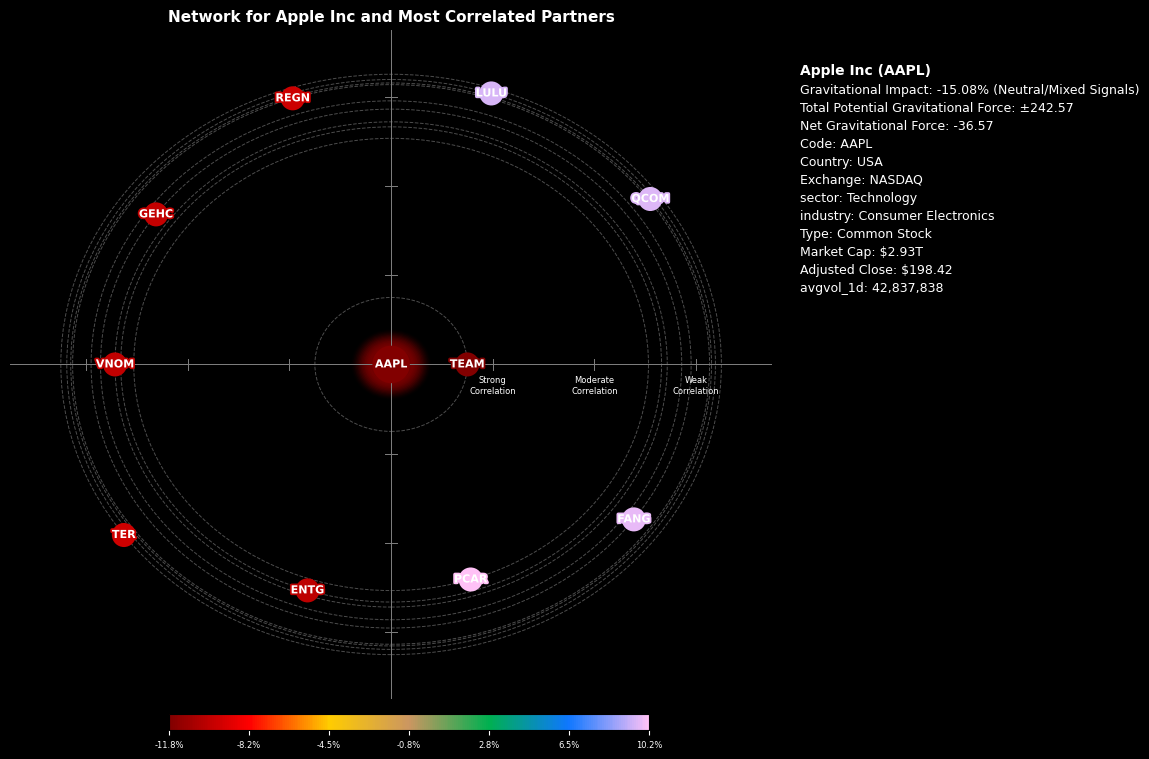

,source,target,Daily Change,six_month_spearman_correlation,three_month_spearman_correlation,unified_correlation,Orbital Radius,Market Cap,Planet Radius,market_cap_influence,gravitational_force,signed_gravitational_force,gravitational_percent
129,AAPL,TEAM,-1.254264,0.854264,0.772406,0.805149,0.000000,52585205760,5.079366e-13,24.685701,19.875665,-19.875665,-11.822616
109,AAPL,PCAR,0.805398,0.784891,0.635112,0.695024,0.712955,48663699456,4.815228e-13,24.608199,17.103280,17.103280,10.173521
37,AAPL,ENTG,-5.375534,0.823626,0.665483,0.728740,0.764361,11847050240,0.000000e+00,23.195345,16.903384,-16.903384,-10.054618
140,AAPL,VNOM,-2.587018,0.804930,0.669851,0.723882,0.786837,12268126208,1.190320e-14,23.230270,16.815984,-16.815984,-10.002630
53,AAPL,GEHC,-1.176310,0.743856,0.645539,0.684866,0.843729,33361500160,3.528545e-13,24.230668,16.594755,-16.594755,-9.871036
42,AAPL,FANG,3.736691,0.702897,0.648846,0.670466,0.880863,45259759616,4.568086e-13,24.535684,16.450354,16.450354,9.785142
119,AAPL,REGN,-1.239513,0.832351,0.533026,0.652756,0.953483,57139900416,5.362474e-13,24.768768,16.167967,-16.167967,-9.617171
117,AAPL,QCOM,1.389607,0.671784,0.591789,0.623787,0.961002,172243255296,9.123050e-13,25.872174,16.138727,16.138727,9.599778
81,AAPL,LULU,0.909623,0.815029,0.569556,0.667746,0.976507,28657571840,3.010556e-13,24.078684,16.078435,16.078435,9.563915
130,AAPL,TER,-3.294145,0.845110,0.576882,0.684173,1.000000,14065626112,5.850272e-14,23.367000,15.987080,-15.987080,-9.509574


In [ ]:
# --- MODIFIED: Network Diagram Plotting Function ---
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import random # Added random for shuffling node positions
import matplotlib.patheffects as path_effects # Import for text outline

def plot_ticker_network_visual(source_ticker, processed_data_df, source_data_df, screener_data_df):
    """
    Plots a network graph for a specific ticker and its most correlated partners.
    Includes a detailed information box for the source ticker.
    All data is sourced from the processed_data_df.
    """
    # Extract scalar values from source_data_df
    if source_data_df.empty or source_ticker not in source_data_df['ticker'].values:
        print(f"Source ticker {source_ticker} not found in source_data_df.")
        return

    source_info_row_from_source_data = source_data_df[source_data_df['ticker'] == source_ticker].iloc[0]
    net_gravitational_force = source_info_row_from_source_data['net_gravitational_force']
    max_potential_force = source_info_row_from_source_data['max_potential_force']
    gravitational_impact = source_info_row_from_source_data['gravitational_impact']


    # Filter for connections related to the source ticker
    ticker_connections = processed_data_df[processed_data_df['source'] == source_ticker].copy()

    if ticker_connections.empty:
        print(f"No connections found for ticker {source_ticker} as the source within the provided data.")
        return

    # Filter out any potential self-loops that might have slipped through, although they should be handled by process_and_score_stocks
    ticker_connections = ticker_connections[ticker_connections['source'] != ticker_connections['target']].copy()

    # Ensure the edge attributes list matches the columns available in ticker_connections
    # Corrected based on the expected columns from process_and_score_stocks
    edge_attributes = [
        'Orbital Radius',
        'Planet Radius',
        'gravitational_percent', # Use gravitational_percent for coloring
        'Daily Change',
        'Market Cap',
        'six_month_spearman_correlation',
        'three_month_spearman_correlation',
    ]

    # Create the graph
    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                edge_attributes)

    # Add the source ticker node explicitly if it's not already added as a target
    if source_ticker not in G.nodes():
        G.add_node(source_ticker)

    # Use subplots to have more control over the layout (graph on left, info on right)
    fig, (ax_main, ax_info) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [3, 1]})
    fig.patch.set_facecolor('black')
    ax_main.set_facecolor('black')
    ax_info.set_facecolor('black')

    # --- Reticle and Orbits on the main axis ---
    reticle_color = 'gray'
    ax_main.axhline(0, color=reticle_color, linestyle='-', linewidth=0.7)
    ax_main.axvline(0, color=reticle_color, linestyle='-', linewidth=0.7)

    radii = {'Strong': 0.4, 'Moderate': 0.8, 'Weak': 1.2}
    tick_length = 0.025

    for strength, r in radii.items():
        ax_main.plot([-tick_length, tick_length], [r, r], color=reticle_color, linewidth=0.7)
        ax_main.plot([-tick_length, tick_length], [-r, -r], color=reticle_color, linewidth=0.7)
        ax_main.plot([r, r], [-tick_length, tick_length], color=reticle_color, linewidth=0.7)
        ax_main.plot([-r, -r], [-tick_length, tick_length], color=reticle_color, linewidth=0.7)

    # Add labels for the reticle just below the tick marks on the positive x-axis
    label_offset_y = 0.05
    ax_main.text(radii['Strong'], -label_offset_y, 'Strong\nCorrelation', color='white', ha='center', va='top', fontsize=6)
    ax_main.text(radii['Moderate'], -label_offset_y, 'Moderate\nCorrelation', color='white', ha='center', va='top', fontsize=6)
    ax_main.text(radii['Weak'], -label_offset_y, 'Weak\nCorrelation', color='white', ha='center', va='top', fontsize=6)


    pos = {}
    pos[source_ticker] = (0, 0)

    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker]
    num_connections = len(actual_target_connections)

    if num_connections > 0:
        angles = [i * (2 * np.pi / num_connections) for i in range(num_connections)]
        random.shuffle(angles)

        # Calculate min and max orbital radius from the filtered connections
        min_orbital_radius = actual_target_connections['Orbital Radius'].min()
        max_orbital_radius = actual_target_connections['Orbital Radius'].max()
        # Handle the case where all orbital radii are the same to avoid division by zero
        radius_range = max_orbital_radius - min_orbital_radius if max_orbital_radius != min_orbital_radius else 1.0


        for i, target_node_name in enumerate(list(actual_target_connections['target'])):
            row = actual_target_connections[actual_target_connections['target'] == target_node_name].iloc[0]
            orbital_radius = row['Orbital Radius']

            # Use the already scaled orbital radius from processed_data_df
            scaled_orbital_radius = orbital_radius # This is now the value between 0 and 1

            min_distance = 0.3
            current_orbital_radius = scaled_orbital_radius + min_distance


            orbit_patch = plt.Circle((0, 0), current_orbital_radius, fill=False, linestyle='--', edgecolor=reticle_color, linewidth=0.7, alpha=0.6)
            ax_main.add_patch(orbit_patch)

            angle = angles[i]
            x = current_orbital_radius * np.cos(angle)
            y = current_orbital_radius * np.sin(angle)
            pos[target_node_name] = (x, y)

    # --- Node Sizing and Coloring ---
    min_planet_size, max_planet_size = 0.05, 1.5
    epsilon = 1e-9

    # Get min/max market caps from the processed_data_df for consistent scaling within this plot
    # Include the source ticker's market cap for scaling if it's not already a target
    all_market_caps = processed_data_df['Market Cap'].tolist()
    source_info_row = processed_data_df[processed_data_df['source'] == source_ticker]
    source_market_cap_for_scaling = source_info_row['Market Cap'].iloc[0] if not source_info_row.empty else None

    if source_market_cap_for_scaling is not None:
         all_market_caps.append(source_market_cap_for_scaling)

    global_min_market_cap = min(all_market_caps) if all_market_caps else epsilon
    global_max_market_cap = max(all_market_caps) if all_market_caps else epsilon

    log_min_mc, log_max_mc = np.log(max(global_min_market_cap, epsilon)), np.log(max(global_max_market_cap, epsilon))


    # Calculate source node size using its market cap from processed_data_df
    source_market_cap = source_info_row['Market Cap'].iloc[0] if not source_info_row.empty else epsilon
    source_market_cap = max(source_market_cap, epsilon)
    log_source_mc = np.log(source_market_cap)
    normalized_source_mc = 0.0 if log_max_mc == log_min_mc else (log_source_mc - log_min_mc) / (log_max_mc - log_min_mc)
    source_planet_radius = min_planet_size + (normalized_source_mc * (max_planet_size - min_planet_size))
    source_node_size = 300 + (source_planet_radius * 500)

    node_sizes_dict = {node: 300 + (ticker_connections[ticker_connections['target'] == node]['Planet Radius'].values[0] * 500) if node != source_ticker else source_node_size for node in G.nodes()}
    node_sizes_list = [node_sizes_dict.get(node, 300) for node in G.nodes()]

    # --- Use gravitational_percent from processed_data_df for coloring ---
    colors = ['#820000', '#FF0000', '#FFCC00', '#CB9661', '#00B050', '#0E77FF', '#FFC1F6']
    cmap = mcolors.LinearSegmentedColormap.from_list('weight_cmap', colors)

    # Determine min/max gravitational_percent for normalization to the colormap range (-1 to 1)
    all_gravitational_percent = processed_data_df['gravitational_percent'].values
    min_gravitational_percent, max_gravitational_percent = np.min(all_gravitational_percent), np.max(all_gravitational_percent)
    norm_gravitational_percent = mcolors.Normalize(vmin=min_gravitational_percent, vmax=max_gravitational_percent)

    node_colors_list = []
    # Ensure gravitional_impact is a scalar float
    gravitational_impact_scalar = float(gravitational_impact)
    for node in G.nodes():
        if node == source_ticker:
             # Color the source node based on the overall gravitional_impact
            # Handle the case where gravitional_impact is 0 to avoid zero range in normalization
            if gravitational_impact_scalar == 0:
                norm_source = mcolors.Normalize(vmin=np.min(processed_data_df['gravitational_percent'].values), vmax=np.max(processed_data_df['gravitational_percent'].values))
            else:
                # Normalize based on the min/max gravitational_impact
                norm_source = mcolors.Normalize(vmin=min_gravitational_percent, vmax=max_gravitational_percent)

            source_node_color = cmap(norm_source(gravitational_impact_scalar))
            node_colors_list.append(source_node_color)
        else:
            # Color target nodes based on their gravitational_percent
            gravitational_percent_value = processed_data_df[(processed_data_df['source'] == source_ticker) & (processed_data_df['target'] == node)]['gravitational_percent'].values
            if gravitational_percent_value.size > 0:
                node_colors_list.append(cmap(norm_gravitational_percent(gravitational_percent_value[0])))
            else:
                # Default color if weight is not found (shouldn't happen with correct filtering)
                node_colors_list.append('gray')


    # --- Draw Aura and Nodes on the main axis ---
    aura_base_radius = np.sqrt(source_node_size / 300) * 0.05
    # Draw auras only for the source node
    for i in range(1, 15):
        aura = plt.Circle(pos[source_ticker], aura_base_radius * (1 + i * 0.07), color=source_node_color, alpha=0.3 * (1 - (i / 15)))
        ax_main.add_patch(aura)

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=1.0, linewidths=0, ax=ax_main)

    # --- Draw Labels on the main axis ---
    node_color_map = dict(zip(G.nodes(), node_colors_list))
    for node in G.nodes():
        if node in pos:
            node_x, node_y = pos[node]
            node_color = node_color_map[node]
            txt = ax_main.text(node_x, node_y, str(node), color='white', fontweight='bold', fontsize=8, ha='center', va='center')
            txt.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground=node_color), path_effects.Normal()])

    # Fetch company name for the title from screener_data_df
    source_screener_info_for_title = screener_data_df[screener_data_df['code'] == source_ticker]
    company_name = source_screener_info_for_title['name'].iloc[0] if not source_screener_info_for_title.empty and 'name' in source_screener_info_for_title.columns else source_ticker
    ax_main.set_title(f'Network for {company_name} and Most Correlated Partners', color='white', fontsize=11, fontweight='bold')
    ax_main.axis('off')
    ax_main.set_xlim(-1.5, 1.5)
    ax_main.set_ylim(-1.5, 1.5)

    # --- Create Information Box on the right axis ---
    # Get source ticker info from screener_data_df
    source_screener_info = screener_data_df[screener_data_df['code'] == source_ticker].iloc[0] if not screener_data_df[screener_data_df['code'] == source_ticker].empty else None
    # Use the source_data_df for gravitational impact and force values
    source_processed_info = source_data_df[source_data_df['ticker'] == source_ticker].iloc[0] if not source_data_df[source_data_df['ticker'] == source_ticker].empty else None


    if source_screener_info is None or source_processed_info is None:
         print(f"Warning: Source ticker {source_ticker} not found in necessary dataframes for info box.")
         info_text = "Information not available."
         company_name_info = source_ticker # Use ticker as name if not found
    else:
        # Determine gravitional force text
        if gravitational_impact >= 90:
            score_meaning = "Strong Increase Signal"
        elif gravitational_impact > 70:
            score_meaning = "Increase Signal"
        elif gravitational_impact > 40:
            score_meaning = "Weak Increase Signal"
        elif gravitational_impact <= -90:
            score_meaning = "Strong Decrease Signal"
        elif gravitational_impact < -70:
            score_meaning = "Decrease Signal"
        elif gravitational_impact < -40:
            score_meaning = "Decrease Signal"
        else:
            score_meaning = "Neutral/Mixed Signals"

        # Format Market Cap for readability (using Market Cap from screener_data_df as it's the most reliable source for current market cap)
        market_cap = source_screener_info.get('market_capitalization', 0)
        if market_cap > 1_000_000_000_000:
            market_cap_str = f"${market_cap/1_000_000_000_000:.2f}T"
        elif market_cap > 1_000_000_000:
            market_cap_str = f"${market_cap/1_000_000_000:.2f}B"
        else:
            market_cap_str = f"${market_cap/1_000_000:.2f}M"

        # Assuming 'Daily Change' is in percentage in screener_data_df
        daily_change_percent = source_screener_info.get('last_day_change', np.nan)


        # Format the information string, using screener_data_df for specific fields and source_data_df for gravitational values
        info_text = (
            # Divide prediction_score_scalar by 100 for display as percentage
            f"Gravitational Impact: {gravitational_impact:.2f}% ({score_meaning})\n"
            f"Total Potential Gravitational Force: ±{max_potential_force:.2f}\n"
            f"Net Gravitational Force: {net_gravitational_force:.2f}\n"
            f"Code: {source_ticker}\n"
            # Get Country, Exchange, Sector, Industry, Type from screener_data_df
            f"Country: {source_screener_info.get('Country', 'N/A')}\n"
            f"Exchange: {source_screener_info.get('Exchange', 'N/A')}\n"
            f"sector: {source_screener_info.get('sector', 'N/A')}\n"
            f"industry: {source_screener_info.get('industry', 'N/A')}\n"
            f"Type: {source_screener_info.get('Type', 'N/A')}\n"
            f"Market Cap: {market_cap_str}\n"
            # Assuming adjusted_close and avgvol_1d are in screener_data_df
            f"Adjusted Close: ${source_screener_info.get('adjusted_close', 0):.2f}\n"
            f"avgvol_1d: {int(source_screener_info.get('avgvol_1d', 0)):,}"
        )
        # Corrected access to the 'name' attribute from the Series
        company_name_info = source_screener_info['name'] if 'name' in source_screener_info and not source_screener_info.empty else source_ticker


    # Add the text to the info axis, adjusting the y position to reduce the gap
    ax_info.text(0.05, 0.95, f"{company_name_info} ({source_ticker})", transform=ax_info.transAxes, fontsize=10, fontweight='bold', color='white', ha='left', va='top')
    ax_info.text(0.05, 0.92, info_text, transform=ax_info.transAxes, fontsize=9, color='white', ha='left', va='top', linespacing=1.5)
    ax_info.axis('off')

    # --- ADDED BACK: Add Colorbar Legend at the bottom of the main graph axis ---
    cbar_ax = fig.add_axes([0.145, 0.08, 0.4, 0.02]) # Adjusted position [left, bottom, width, height]
    # Use the same colormap and normalization as used for the target nod
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_gravitational_percent)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

    # Set the ticks and labels for the colorbar based on the range of normalized weights
    cbar.set_ticks(np.linspace(min_gravitational_percent, max_gravitational_percent, 7))
    # Generate labels that represent the range of weights, formatted as percentages
    labels = [f'{val:.1f}%' for val in np.linspace(min_gravitational_percent, max_gravitational_percent, 7)]
    cbar.set_ticklabels(labels)

    # Style the colorbar labels
    cbar.ax.tick_params(colors='white', labelsize=6)


    plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make room for colorbar
    plt.show()

## ---------- MODIFIED: Run App ---------------
min_nodes = 10
max_nodes = 20
threshold_percent = 0.9

# User input Ticker
source_ticker = 'AAPL' # Changed back to MSFT for initial test

# Process the data for the network diagram
processed_data_df, source_data_df = process_and_score_stocks(
    six_month_spearman_lagged_correlations,
    three_month_spearman_lagged_correlations,
    screener_data_df,
    source_ticker,
    min_nodes,
    max_nodes,
    threshold_percent,
    )

# Pass the score and the prediction_score_df to the plotting function
plot_ticker_network_visual(source_ticker, processed_data_df, source_data_df, screener_data_df)

processed_data_df

##List of Top Predictions

In [8]:
import pandas as pd
top_gravitational_impacts = []

# Ensure unified_correlation_df is created from six_month_spearman_lagged_correlations
# assuming unified_correlation_df is meant to represent the base correlations
# based on the usage in the provided code for process_and_score_stocks.
# If unified_correlation_df should be different, please adjust this.
unified_correlation_df = six_month_spearman_lagged_correlations.copy()


# Iterate through each ticker in the unified_correlation_df
for ticker in tqdm(unified_correlation_df.index, desc="Processing tickers for gravitational impact"):
    try:
        # Run each ticker through the process_and_score_stocks function
        # Note: The function previously returned processed_data_df and prediction_score.
        # It now returns processed_data_df, net_gravitational_force, max_potential_force, gravitational_impact
        # We need to unpack the new return values.
        processed_df, source_data = process_and_score_stocks(
            six_month_spearman_lagged_correlations, # Pass the 6-month correlation
            three_month_spearman_lagged_correlations, # Pass the 3-month correlation
            screener_data_df,
            ticker, # Use the current ticker as source_ticker
            min_nodes,
            max_nodes,
            threshold_percent,
        )

        # Append the results to the list
        # Access the scalar values from the returned source_data DataFrame
        if not source_data.empty:
            top_gravitational_impacts.append({
                'ticker': ticker,
                'net_gravitational_force': source_data['net_gravitational_force'].iloc[0],
                'max_potential_force': source_data['max_potential_force'].iloc[0],
                'gravitational_impact': source_data['gravitational_impact'].iloc[0]
            })
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")

# Create a DataFrame from the results
gravitational_impact_df = pd.DataFrame(top_gravitational_impacts)

# Sort by gravitational_impact in descending order for top positive impacts
top_positive_impacts = gravitational_impact_df.sort_values(by='gravitational_impact', ascending=False).head(10).reset_index(drop=True)

# Sort by gravitational_impact in ascending order for top negative impacts
top_negative_impacts = gravitational_impact_df.sort_values(by='gravitational_impact', ascending=True).head(10).reset_index(drop=True)


# Display the tables
print("Top 10 Positive Gravitational Impact Tickers:")
print(top_positive_impacts[['ticker', 'net_gravitational_force', 'max_potential_force', 'gravitational_impact']].to_string(index=False, formatters={'net_gravitational_force': '{:.2f}'.format, 'max_potential_force': '{:.2f}'.format, 'gravitational_impact': '{:.2f}'.format}))

print("\nTop 10 Negative Gravitational Impact Tickers:")
print(top_negative_impacts[['ticker', 'net_gravitational_force', 'max_potential_force', 'gravitational_impact']].to_string(index=False, formatters={'net_gravitational_force': '{:.2f}'.format, 'max_potential_force': '{:.2f}'.format, 'gravitational_impact': '{:.2f}'.format}))

Processing tickers for gravitational impact:   0%|          | 0/259 [00:00<?, ?it/s]

No correlation data found for source ticker CHYM.
Top 10 Positive Gravitational Impact Tickers:
ticker net_gravitational_force max_potential_force gravitational_impact
   EXE                  172.46              381.46                45.21
   PAA                   99.26              247.35                40.13
   VOD                  123.81              321.87                38.46
    JD                   86.06              241.48                35.64
  GEHC                   85.36              253.01                33.74
  FSLR                   97.62              292.00                33.43
  PAYX                   82.97              251.79                32.95
  MANH                   85.81              267.84                32.04
  FFIV                   80.53              254.93                31.59
  TTWO                   78.20              250.73                31.19

Top 10 Negative Gravitational Impact Tickers:
ticker net_gravitational_force max_potential_force gravitational_

#Dash App with Solar System

##Setup

In [20]:
# Dash App Setup

#Terminal Command
#ngrok config add-authtoken 2yPWVwCXJDsY9JkhLhnrn549R5E_5b2uFuh7R4ER3fLJWLU59

# Install necessary libraries (run this cell first)
!pip install -q dash dash-bootstrap-components plotly pyngrok

# --- Import necessary libraries ---
from dash import Dash, html, dcc, Input, Output # We need dcc for interactive components and Input/Output for callbacks
import os
from pyngrok import ngrok
from google.colab import userdata

# # --- Configure Ngrok for public access ---
# NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
# os.environ["NGROK_AUTH_TOKEN"] = NGROK_AUTH_TOKEN

# --- Configure Ngrok for public access ---
# This part remains the same to create a public URL for your app
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    # Use pyngrok to set the auth token programmatically
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
except userdata.SecretNotFoundError:
    print("NGROK_AUTH_TOKEN not found in Colab secrets. Please add it.")
    # You might want to handle this case, e.g., by exiting or using a default token if applicable
    exit()


# Define the port your Dash app will run on.
DASH_PORT = 8051

In [45]:
# Kills all ngrok processes that pyngrok started
print("Attempting to kill all active ngrok tunnels...")
ngrok.kill()
print("All ngrok tunnels should now be terminated.")

# Add a short delay to ensure the process is killed
import time
time.sleep(5)

Attempting to kill all active ngrok tunnels...
All ngrok tunnels should now be terminated.


In [26]:
# Create a public ngrok tunnel to the specified port.
print("Establishing Ngrok tunnel...")
public_url = ngrok.connect(DASH_PORT)
print(f"🚀 Your Dash app will be accessible at: {public_url}")

Establishing Ngrok tunnel...
🚀 Your Dash app will be accessible at: NgrokTunnel: "https://64fc-35-185-42-246.ngrok-free.app" -> "http://localhost:8051"


## Dash App

In [44]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.colors as mcolors # Import mcolors
from dash import Dash, dcc, html
from dash.dependencies import Input, Output

# Note: The dummy data section below is commented out.
# In a real application, you would load your actual data here.
# The code assumes that 'processed_data_df', 'source_data_df',
# 'screener_data_df', 'six_month_spearman_lagged_correlations',
# and 'three_month_spearman_lagged_correlations' are already
# defined and populated from previous cells in your notebook.
'''
# --- Start Dummy Data (Commented Out) ---
# In a real application, this data would be loaded from a file, database, or API.
# It's hardcoded here for demonstration purposes to make the example self-contained.

# Static dummy data for the source ticker 'AAPL'
source_ticker = 'AAPL'

# Static dummy data representing pre-processed financial metrics and correlations.
# This DataFrame simulates the output of a data processing pipeline.
data = {
    'source': ['AAPL'] * 10,
    'target': ['AMZN', 'GOOG', 'GOOGL', 'QCOM', 'CMCSA', 'SBUX', 'TEAM', 'ADBE', 'PEP', 'PDD'],
    'Daily Change': [-0.53, -0.62, -0.59, -2.51, -0.74, -1.12, -1.25, -5.32, -1.10, -2.76],
    'six_month_spearman_correlation': [0.7087, 0.7040, 0.6980, 0.6720, 0.6088, 0.6364, 0.8536, 0.7937, 0.6456, 0.1835],
    'three_month_spearman_correlation': [0.2712, 0.1193, 0.1070, 0.6203, 0.4797, 0.5048, 0.7724, 0.1989, 0.2695, 0.6073],
    'unified_correlation': [0.4462, 0.3532, 0.3434, 0.6410, 0.5313, 0.5575, 0.8049, 0.4368, 0.4199, 0.4378],
    'Orbital Radius': [0.7, 0.8, 0.9, 0.6, 1.0, 1.1, 0.5, 1.2, 1.3, 1.4], # This is the raw data used for scaling the visual orbits.
    'Market Cap': [2.25e+12, 2.13e+12, 2.13e+12, 1.70e+11, 1.31e+11, 1.06e+11, 5.17e+10, 1.67e+11, 1.79e+11, 1.43e+11],
    'Planet Radius': [1.0000, 0.9848, 0.9848, 0.3153, 0.2459, 0.1903, 0.0000, 0.3107, 0.3298, 0.3298, 0.2693], # Raw data for scaling planet size.
    'gravitational_percent': [-15.58, -12.20, -11.87, -11.64, -8.75, -8.42, -8.41, -7.89, -7.78, -7.46]
}
processed_data_df

# Add aggregated metrics for the source ticker to the DataFrame for easy access in the plot.
processed_data_df['gravitational_impact'] = -59.46
processed_data_df['net_gravitational_force'] = -477.29
processed_data_df['max_potential_force'] = 802.70

# Static dummy data for general stock information (screener data).
screener_data_dict = {
    'code': ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'QCOM', 'CMCSA', 'SBUX', 'TEAM', 'ADBE', 'PEP', 'PDD', 'MSFT', 'TSLA'],
    'name': ['Apple Inc', 'Amazon.com Inc', 'Alphabet Inc Class C', 'Alphabet Inc Class A', 'QUALCOMM Inc.', 'Comcast Corporation', 'Starbucks Corporation', 'Atlassian Corporation Plc', 'Adobe Inc.', 'PepsiCo Inc.', 'PDD Holdings Inc.', 'Microsoft Corporation', 'Tesla, Inc.'],
    'sector': ['Technology', 'Consumer Cyclical', 'Communication Services', 'Communication Services', 'Technology', 'Communication Services', 'Consumer Cyclical', 'Technology', 'Technology', 'Consumer Defensive', 'Consumer Cyclical', 'Technology', 'Consumer Cyclical'],
    'industry': ['Consumer Electronics', 'Internet Retail', 'Internet Content & Information', 'Internet Content & Information', 'Semiconductors', 'Cable & Satellite', 'Restaurants', 'Software - Infrastructure', 'Software - Application', 'Beverages - Non-Alcoholic', 'Internet Retail', 'Software - Infrastructure', 'Auto Manufacturers'],
}
screener_data_df = pd.DataFrame(screener_data_dict)

# --- End Dummy Data ---
'''

# --- Plotting Function Definition ---
# This function creates the interactive 3D solar system visualization using Plotly.
def solar_system_visual(source_ticker, processed_data_df, source_data_df, screener_data_df):
    """
    Plots a 3D solar system style interactive network graph with a default isometric view.
    The orbital distances of the "planets" (target tickers) are proportionally scaled
    based on the 'Orbital Radius' column in the data.

    Args:
      source_ticker (str): The ticker symbol for the central "sun".
      processed_data_df (pd.DataFrame): DataFrame with processed financial data and correlations.
      source_data_df (pd.DataFrame): DataFrame containing aggregated metrics for the source ticker.
      screener_data_df (pd.DataFrame): DataFrame with general stock information (name, sector, etc.).

    Returns:
      go.Figure: A Plotly graph object figure for the Dash app to display.
    """
    # Filter the data to get connections for the selected source ticker.
    ticker_connections = processed_data_df[processed_data_df['source'] == source_ticker].copy()
    if ticker_connections.empty:
        # Return an empty figure with a message if no data is found for the source ticker.
        return go.Figure().update_layout(
            title=f"Data not available for {source_ticker}", title_x=0.5,
            paper_bgcolor='black', font_color='white'
        )

    # Extract scalar values from source_data_df for the source ticker
    source_info_row_from_source_data = source_data_df[source_data_df['ticker'] == source_ticker]
    if source_info_row_from_source_data.empty:
        print(f"Source ticker {source_ticker} not found in source_data_df.")
        # Return an empty figure if source ticker data is missing.
        return go.Figure().update_layout(
            title=f"Data not available for {source_ticker}", title_x=0.5,
            paper_bgcolor='black', font_color='white'
        )
    # Get the first row of the source data DataFrame as a Series.
    source_info_row_from_source_data = source_info_row_from_source_data.iloc[0]
    # Extract individual metrics for the source ticker.
    net_gravitational_force = source_info_row_from_source_data['net_gravitational_force']
    max_potential_force = source_info_row_from_source_data['max_potential_force']
    gravitational_impact = source_info_row_from_source_data['gravitational_impact']
    source_planet_radius = source_info_row_from_source_data['source_planet_radius']


    # Filter out any potential self-loops (connections from a ticker to itself).
    ticker_connections = ticker_connections[ticker_connections['source'] != ticker_connections['target']].copy()

    # --- Node Positioning and Orbital Scaling ---
    # The source ticker (sun) is always positioned at the origin (0, 0, 0).
    pos = {source_ticker: (0, 0, 0)}
    # Filter for connections where the current ticker is the target (planets).
    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker].copy()
    num_connections = len(actual_target_connections)

    radii_for_rings = [] # List to store the calculated visual radii for drawing orbit lines.
    fig = go.Figure() # Initialize the Plotly figure object.

    if num_connections > 0:
        # Get the raw 'Orbital Radius' values for the target tickers.
        original_radii = actual_target_connections['Orbital Radius']
        min_rad = original_radii.min()
        max_rad = original_radii.max()
        # Calculate the range of the raw radii to use for scaling.
        # Avoid division by zero if all radii are the same.
        rad_range = max_rad - min_rad if max_rad > min_rad else 1.0

        # Define the minimum and maximum visual distance for the orbits in the plot.
        min_visual_radius = 2
        max_visual_radius = 8.0
        visual_range = max_visual_radius - min_visual_radius

        # Generate evenly spaced angles for placing planets around the sun in a circle.
        thetas = np.linspace(0, 2 * np.pi, num_connections, endpoint=False)

        # Loop through each target connection to calculate its position in the 3D space.
        for i, (index, row) in enumerate(actual_target_connections.iterrows()):
            target_node_name = row['target']
            original_radius = row['Orbital Radius']

            # --- Proportional Scaling Logic ---
            # 1. Normalize the original radius to a 0-1 scale: (value - min) / range
            # 2. Scale this 0-1 value to our desired visual range (min_visual_radius to max_visual_radius).
            scaled_radius = ((original_radius - min_rad) / rad_range) * visual_range + min_visual_radius
            radii_for_rings.append(scaled_radius)

            # Convert polar coordinates (scaled_radius, theta) to Cartesian coordinates (x, y).
            theta = thetas[i]
            x = scaled_radius * np.cos(theta)
            y = scaled_radius * np.sin(theta)
            z = 0 # All planets are placed on the z=0 plane to create the 2D solar system effect.
            pos[target_node_name] = (x, y, z)

    # --- Add Orbital Rings ---
    # Draw a dotted circle for each unique orbital distance calculated for the planets.
    unique_radii = sorted(list(set(radii_for_rings)))
    for r in unique_radii:
        theta_ring = np.linspace(0, 2 * np.pi, 100) # Generate points to draw a smooth circle.
        x_ring = r * np.cos(theta_ring)
        y_ring = r * np.sin(theta_ring)
        z_ring = np.zeros(100) # Keep the rings on the z=0 plane.
        fig.add_trace(go.Scatter3d(
            x=x_ring, y=y_ring, z=z_ring,
            mode='lines',
            line=dict(color='rgba(100, 100, 100, 0.5)', width=1, dash='dot'), # Style the rings.
            hoverinfo='none' # Rings should not show hover information.
        ))

    # --- Prepare Node Data for Plotting ---
    # Lists to store the x, y, z coordinates, hover text, size, color, and label for each node.
    node_x, node_y, node_z = [], [], []
    hover_texts, node_sizes, node_colors, node_labels = [], [], [], []

    # Define the color spectrum for the nodes.
    colors = ['#FF0000', '#F04435', '#E47C61', '#D9B28B', '#A5BA6F', '#73C255', '#33CC33']
    # Create a colormap from the defined colors.
    cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)

    # Determine normalization for target node colors based on their 'Daily Change'.
    all_daily_changes = processed_data_df['Daily Change'].values
    # Define the range for the Daily Change color scale.
    min_daily_change, max_daily_change = -5, 5
    norm_daily_change = mcolors.Normalize(vmin=min_daily_change, vmax=max_daily_change)

    # Determine normalization for source node color based on the overall 'Gravitational Impact'.
    # Use the range of all gravitational impacts from gravitational_impact_df for consistent scaling across all possible source tickers.
    if 'gravitational_impact_df' in globals() and not gravitational_impact_df.empty:
        all_gravitational_impacts = gravitational_impact_df['gravitational_impact'].values
        # Define the range for the Gravitational Impact color scale.
        min_gravitational_impact, max_gravitational_impact = -90, 90
        norm_gravitational_impact = mcolors.Normalize(vmin=min_gravitational_impact, vmax=max_gravitational_impact)
    else:
        # Fallback normalization if gravitational_impact_df is not available.
        norm_gravitational_impact = mcolors.Normalize(vmin=-100, vmax=100) # Assume a default range of -100% to 100%.


    # --- Loop through each node (sun and planets) to gather its plot properties. ---
    for node_name, coords in pos.items():
        # Append the 3D coordinates of the node.
        node_x.append(coords[0])
        node_y.append(coords[1])
        node_z.append(coords[2])

        # Determine if the current node is the source ticker (sun).
        is_source = (node_name == source_ticker)
        # Get the corresponding information from the screener and processed dataframes.
        screener_info = screener_data_df[screener_data_df['code'] == node_name]
        # For target nodes (planets), get information from ticker_connections (which is a subset of processed_data_df).
        processed_info = ticker_connections[ticker_connections['target'] == node_name]

        # Check if screener information is available for the node.
        if not screener_info.empty:
            screener_info = screener_info.iloc[0] # Get the first row as a Series.

            # Format market cap for readability (e.g., $2.25T, $1.70B).
            market_cap = screener_info.get('market_capitalization', 0)
            if market_cap > 1e12: market_cap_str = f"${market_cap/1e12:.2f}T"
            elif market_cap > 1e9: market_cap_str = f"${market_cap/1e9:.2f}B"
            else: market_cap_str = f"${market_cap/1e6:.2f}M"


            # Create the hover text content based on whether it's the sun or a planet.
            if is_source:
                # For the source node (sun), use data from source_data_df and screener_data_df.
                text = (
                    f"<b>{screener_info.get('name', node_name)} ({node_name})</b><br>"
                    f"Gravitational Impact: {gravitational_impact:.2f}%<br>"
                    f"Net Gravitational Force: {net_gravitational_force:.2f}<br>"
                    f"Max Potential Force: {max_potential_force:.2f}<br>"
                    f"Industry: {screener_info.get('industry', 'N/A')}<br>"
                    f"Sector: {screener_info.get('sector', 'N/A')}<br>"
                    f"Avg Volume (1d): {screener_info.get('avgvol_1d', 'N/A')}<br>"
                    f"Market Cap: {market_cap_str}"
                )
                # Color the source node based on the overall gravitational_impact using the defined colormap and normalization.
                node_color = mcolors.to_hex(cmap(norm_gravitational_impact(gravitational_impact)))
                node_colors.append(node_color)

                # Scale source node size using the pre-calculated 'source_planet_radius' from source_data_df.
                min_visual_size, max_visual_size = 20, 60 # Define the visual size range for nodes.
                # Use the pre-calculated source_planet_radius directly for consistent scaling
                source_node_size_scaled = min_visual_size + (source_planet_radius * (max_visual_size - min_visual_size))
                node_sizes.append(source_node_size_scaled)


            elif not processed_info.empty:
                 # For target nodes (planets), use data from processed_info and screener_data_df.
                 processed_info = processed_info.iloc[0] # Get the first row as a Series.
                 text = (
                    f"<b>{screener_info.get('name', node_name)} ({node_name})</b><br>"
                    f"Unified Correlation: {processed_info['unified_correlation']:.2f}<br>"
                    f"Gravitational Force: {processed_info['gravitational_force']:.2f}<br>"
                    f"Industry: {screener_info.get('industry', 'N/A')}<br>"
                    f"Sector: {screener_info.get('sector', 'N/A')}<br>"
                    f"Avg Volume (1d): {screener_info.get('avgvol_1d', 'N/A')}<br>"
                    f"Daily Change: {processed_info['Daily Change']:.2f}%<br>"
                    f"Market Cap: {market_cap_str}"
                )
                 # Color target nodes based on their 'Daily Change' using the defined colormap and normalization.
                 node_color = mcolors.to_hex(cmap(norm_daily_change(processed_info['Daily Change'])))
                 node_colors.append(node_color)

                 # Scale planet size based on its 'Planet Radius' data from processed_info.
                 min_visual_size, max_visual_size = 20, 60 # Define the visual size range for nodes.
                 node_sizes.append(min_visual_size + (processed_info['Planet Radius'] * (max_visual_size - min_visual_size)))
            else:
                # Fallback hover text, size, and color for nodes with missing processed information.
                text = (
                    f"<b>{screener_info.get('name', node_name)} ({node_name})</b><br>"
                    f"Info unavailable."
                )
                node_sizes.append(15)
                node_colors.append('gray') # Default color to gray.

            # Append the generated hover text and node label.
            hover_texts.append(text)
            node_labels.append(node_name)
        else:
            # Fallback hover text, size, and color for nodes with missing screener information.
            hover_texts.append(f"<b>{node_name}</b><br>Info unavailable.")
            node_sizes.append(15)
            node_colors.append('gray') # Default color to gray.
            node_labels.append(node_name)


    # --- Configure and Add Node Trace ---
    # Add the trace for the nodes (planets and sun) to the figure.
    fig.add_trace(go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers+text', # Display markers (nodes) and text labels.
        hoverinfo='text', # Display the custom hover text when hovering over a node.
        text=node_labels, # Use ticker symbols as initial text labels.
        textposition='middle center', # Center the node labels within the markers.
        textfont=dict(
            color='white',  # Set font color to white.
            size=10,
            family='sans-serif', # Use a standard font.
        ),
        marker=dict(
            showscale=False, # Hide this color scale as we will create a custom legend
            # Use the colormap defined earlier for coloring the markers.
            colorscale=[[i/(len(colors)-1), color] for i, color in enumerate(colors)],
            color=node_colors, # Use the assigned colors directly for each node.
            size=node_sizes, # Use the calculated sizes for each node.
            opacity=1.0, # Set opacity to 1 for no transparency.
            symbol='circle', # Use circle markers for nodes.
            line=dict(width=0) # Remove white outline around nodes.
        ),
        hovertext=hover_texts, # Use the custom hover text.
    ))

    # --- REMOVED: Add separate invisible trace for horizontal colorbar legend ---
    # This functionality will be replaced by a custom HTML legend in the Dash layout.


    # Make node labels bold in the text list.
    node_labels_bold = [f'<b>{label}</b>' for label in node_labels]
    # Update the text labels for the first trace (the nodes).
    fig.update_traces(selector=dict(mode='markers+text'), text=node_labels_bold)


    # --- Configure Final Layout ---
    # Get the company name for the plot title from screener_data_df.
    company_name_series = screener_data_df[screener_data_df['code'] == source_ticker]['name']
    company_name = company_name_series.iloc[0] if not company_name_series.empty else source_ticker
    fig.update_layout(
        title=f'Financial Solar System for {company_name} ({source_ticker})', # Set the main plot title.
        title_x=0.5, # Center the title horizontally.
        scene=dict(
            # Hide the 3D axes for a cleaner look.
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            # Set the camera for a zoomed-in isometric view.
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                # Adjusted eye position to zoom out slightly
                eye=dict(x=1.5, y=1.5, z=1.5)
            ),
            # Ensure the aspect ratio is based on the data to prevent distortion.
            aspectmode='data'
        ),
        # Adjust margins to make space for the bottom colorbar legend.
        margin=dict(l=0, r=0, b=0, t=40), # Adjusted bottom margin as legend is moved
        showlegend=False, # Hide the default legend.
        paper_bgcolor='black', # Set the background color of the figure.
        plot_bgcolor='black', # Set the background color of the plot area.
        font_color='white', # Set the default font color.
         # Make node and text sizes dynamic with zoom.
        uniformtext_minsize=10, # Minimum font size (in px).
        uniformtext_mode='hide', # Hide text if it goes below minsize.
    )
    return fig


# --- Initialize the Dash Application ---
app = Dash(__name__)

# --- Prepare Data for Controls ---
# Create a list of dictionaries for the dropdown options from screener_data_df.
ticker_options = [{'label': row['name'] + f" ({row['code']})", 'value': row['code']} for index, row in screener_data_df.iterrows()]
# Set a default ticker for when the app first loads. Choose AAPL if available, otherwise the first ticker in the list.
default_ticker = 'AAPL' if 'AAPL' in screener_data_df['code'].unique() else screener_data_df['code'].iloc[0]

# Define the custom legend labels and colors (matching the colormap used in the plot)
legend_labels = [
    "Large\nDecrease", "Decrease", "Slight\nDecrease",
    "Stable/Mixed",
    "Slight\nIncrease", "Increase", "Large\nIncrease"
]
# Define the colors corresponding to the labels (matching the colormap)
legend_colors = ['#FF0000', '#F04435', '#E47C61', '#D9B28B', '#A5BA6F', '#73C255', '#33CC33']

# Define the positions for the labels along the horizontal color bar (0 to 1)
# These positions should roughly correspond to where the colors transition
# Based on 7 labels, evenly spaced positions might be appropriate
label_positions = np.linspace(0, 1, len(legend_labels))

# --- Define the App Layout ---
# This section defines the HTML structure of the web page using Dash components.
app.layout = html.Div(style={'backgroundColor': 'black', 'color': 'white', 'font-family': 'sans-serif'}, children=[
    # Main title of the dashboard.
    html.H1("Financial Planetarium", style={'textAlign': 'center', 'color': '#50FBF9', 'paddingTop': '20px'}),

    # Container for the dropdown menu to select the ticker.
    html.Div([
        html.Label("Select Ticker:", style={'marginRight': '10px'}),
        dcc.Dropdown(
            id='ticker-dropdown', # Unique ID for the dropdown component.
            options=ticker_options, # Options populated from screener_data_df.
            value=default_ticker, # Set the initial value of the dropdown.
            style={'width': '300px', 'display': 'inline-block', 'color': '#333'} # Style the dropdown.
        ),
    ], style={'textAlign': 'center', 'padding': '20px'}), # Style the container div.

    # The graph component that will display our Plotly figure.
    dcc.Graph(
        id='network-graph', # Unique ID for the graph component.
        figure={}, # Initialize with an empty figure. The callback will update this.
        # Adjust the height and width of the graph component to control the plot area size.
        style={'height': '80vh', 'width': '70vw', 'margin': 'auto'} # Example: Set height to 80% of the viewport height, width to 70% of viewport width, and center it using margin: 'auto'.
    ),

    # --- Custom Legend Section ---
    html.Div(style={'textAlign': 'center', 'padding': '20px'}, children=[
        html.H3("Gravitational Impact Legend", style={'color': 'white', 'marginBottom': '10px'}),
        # Container for the color bar
        html.Div(style={
            'width': '70%', # Set the width of the color bar container
            'height': '20px', # Set the height of the color bar
            'margin': '10px auto', # Center the color bar and add some vertical margin
            'background': 'linear-gradient(to right, {}, {}, {}, {}, {}, {}, {})'.format(*legend_colors), # Create the gradient background
            'borderRadius': '5px' # Optional: add rounded corners
        }),
        # Container for the labels below the color bar
        html.Div(style={
            'width': '70%', # Match the width of the color bar container
            'margin': 'auto', # Center the label container
            'display': 'flex', # Use flexbox for horizontal alignment of labels
            'justifyContent': 'space-between', # Distribute labels evenly
            'padding': '0 5px', # Add some padding to the sides
        }, children=[
            # Create a Span for each label, with line breaks where needed
             html.Span([html.Br() if part == '' else part for part in label.split('\n')], style={
                 'textAlign': 'center', # Center the text of each label
                 'fontSize': '0.8em', # Adjust font size
                 'whiteSpace': 'pre-wrap' # Allow pre-formatted white space, including line breaks
            }) for label in legend_labels
        ])
    ])
])

# --- Define the Callback ---
# This function connects the dropdown input to the graph output.
# It tells Dash to re-run this function whenever the dropdown's value changes.
@app.callback(
    Output('network-graph', 'figure'), # The property of the component to update (the 'figure' property of the 'network-graph' component).
    Input('ticker-dropdown', 'value')  # The component and property that triggers the update (the 'value' property of the 'ticker-dropdown' component).
)
def update_network_graph(selected_ticker):
    """
    This function is called by Dash whenever the dropdown value changes.
    It generates the Plotly figure for the selected stock by calling
    the solar_system_visual function with the relevant data.

    Args:
        selected_ticker (str): The ticker symbol selected from the dropdown.

    Returns:
        go.Figure: The Plotly figure to be displayed in the dcc.Graph component.
    """
    # Check if a ticker has been selected.
    if not selected_ticker:
        # Return an empty figure with a message if no ticker is selected.
        return go.Figure().update_layout(
            title="Please select a ticker.", title_x=0.5,
            paper_bgcolor='black', font_color='white'
        )

    # Process the data for the selected ticker using the pre-defined function.
    # This function is assumed to be available from previous cells and takes
    # the necessary correlation and screener dataframes as input.
    # It returns the processed data for plotting and aggregated source data.
    processed_data_df, source_data_df = process_and_score_stocks(
        six_month_spearman_lagged_correlations,
        three_month_spearman_lagged_correlations,
        screener_data_df,
        selected_ticker,
        min_nodes=10, # Use appropriate values for filtering the number of connected nodes.
        max_nodes=20,
        threshold_percent=0.9 # Use an appropriate threshold for filtering connections by gravitational force.
    )

    # Call our main plotting function to generate the visualization figure.
    # This function takes the selected ticker and the processed dataframes as input.
    fig = solar_system_visual(selected_ticker, processed_data_df, source_data_df, screener_data_df)
    return fig # Return the generated figure to the Dash app to be displayed.

# --- Run the Dash Server ---
if __name__ == '__main__':
    # This block is executed when the script is run directly.
    # It starts the Dash web server.
    # `debug=True` enables development mode features like hot-reloading and debugging.
    # `port=8051` specifies the port number the app will listen on.
    app.run(debug=True, port=8051)

<IPython.core.display.Javascript object>